In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Parameters

In [2]:
time_seconds = 10 # in seconds
frequency_sampling = 100 # in Hertz
number_of_frequencies = 100
max_freq = 39.9
max_amplitude = 2

In [3]:
assert (frequency_sampling > (max_freq*2)), "Nyquist won't be happy"

## Generating signals

In [4]:
time = np.arange(0, time_seconds, 1/frequency_sampling)
N = len(time)
phase = np.round(np.random.rand(number_of_frequencies)*2*np.pi,1)
freq = np.round(np.random.rand(number_of_frequencies)*max_freq,1)
amp = np.round(np.random.rand(number_of_frequencies)*max_amplitude,1)
signals = np.cos(2*np.pi*np.outer(freq,time)+phase[:,np.newaxis]) * amp[:, None]
signal = np.sum(signals,0)

### Plotting each one and sum
or there are to many plots so it will plot only first 10

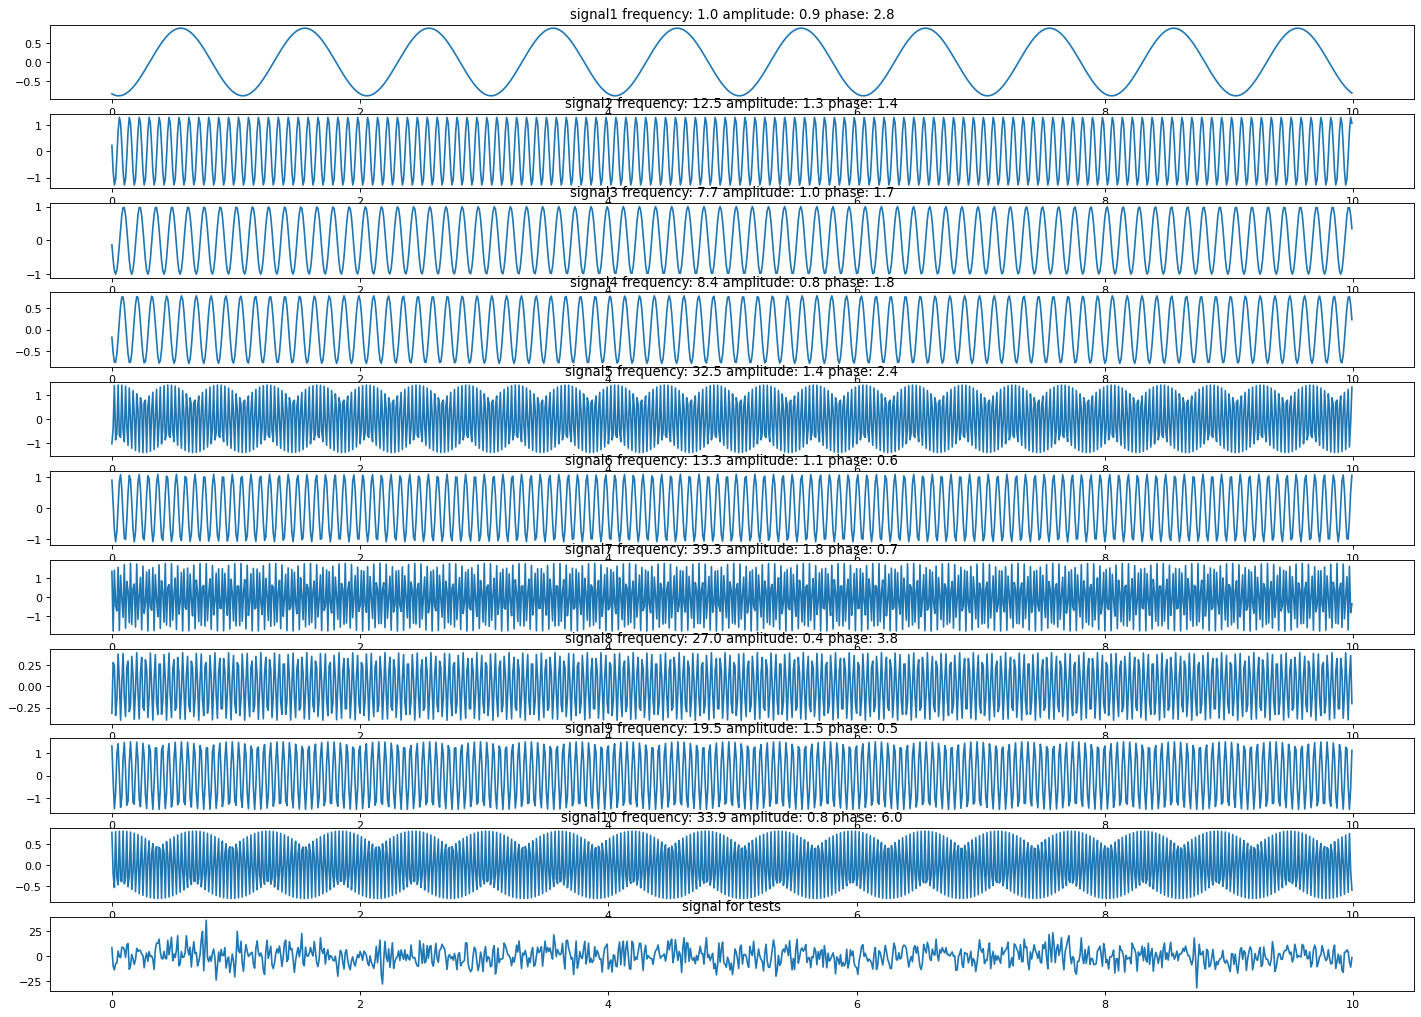

In [5]:
plt.figure(figsize=(22, 16), dpi=80)
temp_N = min([number_of_frequencies,10])
for i in range(temp_N):
    plt.subplot(temp_N+1,1,i+1)
    plt.plot(time, signals[i,:])
    plt.title(f"signal{i+1} frequency: {freq[i]} amplitude: {amp[i]} phase: {phase[i]}")
else:
    plt.subplot(temp_N+1,1,temp_N+1)
    plt.plot(time, signal)
    plt.title(f"signal for tests")

# FFT functions

## common

In [6]:
def commonFFT(signal, Fs):
    N = len(signal)
    frequency_vector = np.arange(0, Fs, Fs/N)
    return frequency_vector, np.abs(np.fft.fft(signal))/N

## modified

In [7]:
def modifiedFFT(signal, Fs):
    N = len(signal)
    frequency_vector = np.arange(0, Fs, Fs/N)
    com_fft = np.abs(np.fft.fft(signal))/N
    com_fft[1:int(np.ceil(N/2)+1)] = com_fft[1:int(np.ceil(N/2)+1)]*2
    com_fft[int(np.ceil(N/2)+1):].fill(0)
    return frequency_vector, com_fft

Calcucalating those FFTs

In [8]:
fvec_common, abs_fft_common = commonFFT(signal, Fs=frequency_sampling)
fvec_modified, abs_fft_modified = modifiedFFT(signal, Fs=frequency_sampling)

Text(0.5, 1.0, 'FFT modified')

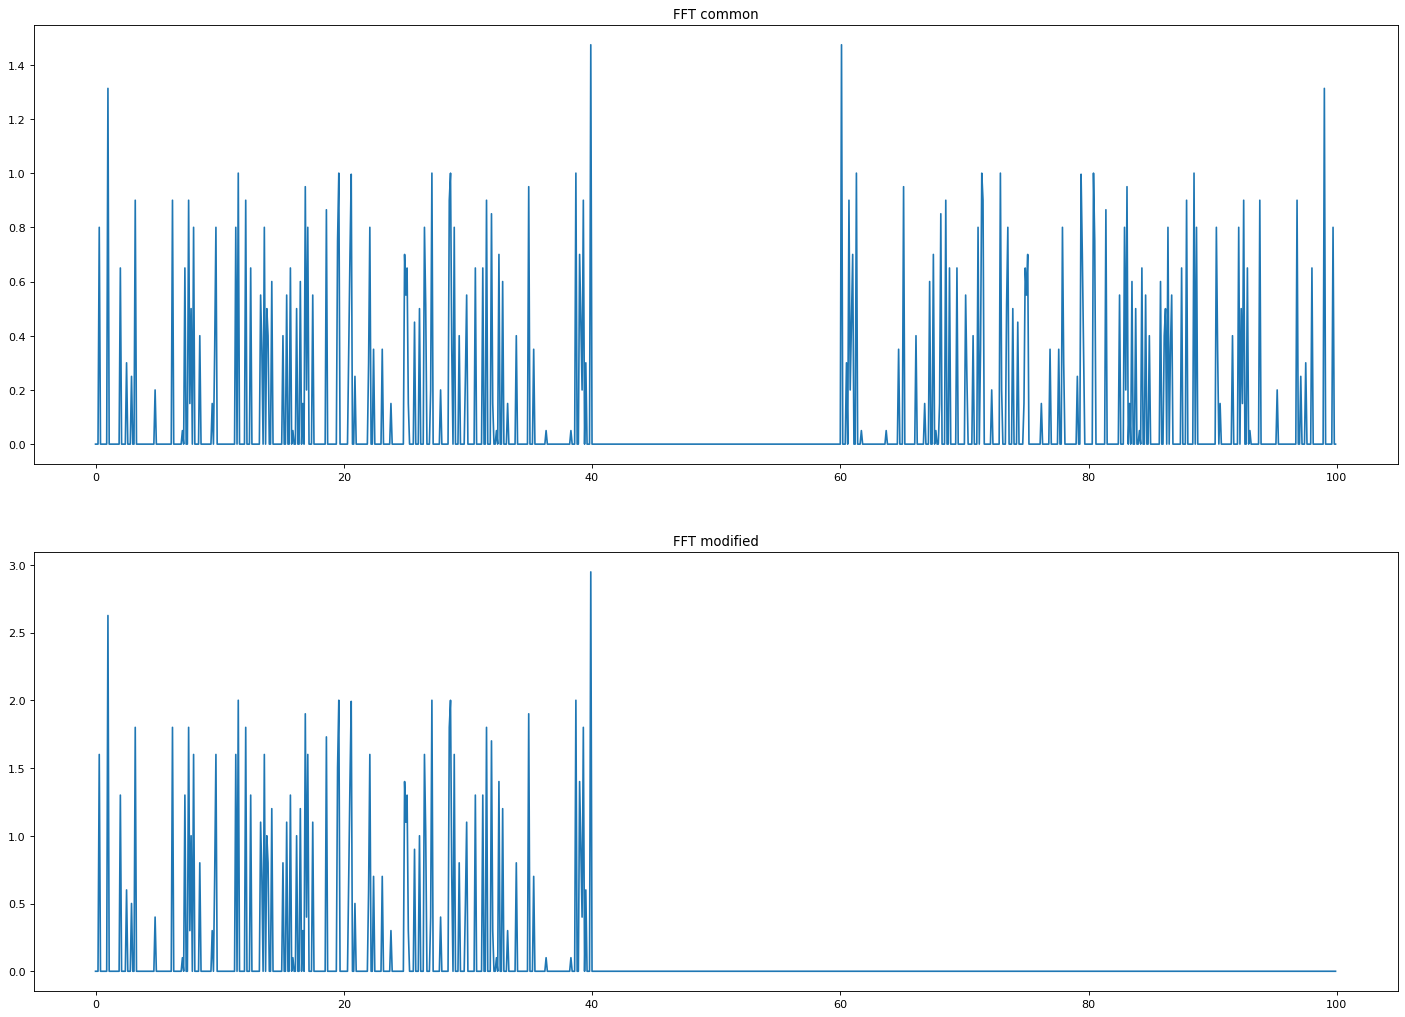

In [9]:
plt.figure(figsize=(22, 16), dpi=80)
plt.subplot(2,1,1)
plt.plot(fvec_common, abs_fft_common)
plt.title(f"FFT common")
plt.subplot(2,1,2)
plt.plot(fvec_modified, abs_fft_modified)
plt.title(f"FFT modified")

# Short summary:
1. We see the amplitudes on modified reflects the one set in the begining of the scripts, but amplitudes on the common FFT equals the half of expected amplitude
2. We see significant part of modified FFT is set to zero, it is we pushed those amplitudes to range (0;Fs/2]
3. We see common FFT plot has line of symmetry at point Fs/2

Quartiles of frequency

In [10]:
def quartiles_fft(abs_fft, fvec):
    cum_energy = np.cumsum(abs_fft**2)
    final_energy = cum_energy[-1]
    q1 = min(fvec[cum_energy>(final_energy*1/4)])
    q2 = min(fvec[cum_energy>(final_energy*2/4)])
    q3 = min(fvec[cum_energy>(final_energy*3/4)])
    return q1, q2, q3

Using the common FFT we can make assumptions:
1. When not taking first element into consideration Q2 should land at frequency sampling divided by 2, the changes can result range of frequency in input signal it would be highest component but not exceding Fs/2, some difference may appear due to Spectral leakage
2. Knowing Q1 we can estimate Q3 using this formula: Q3 = Fs - Q1, so let give it a try

In [11]:
q1_common, q2_common, q3_common = quartiles_fft(abs_fft_common, fvec_common)
print(f"""Using common FFT:
Q1: {q1_common} Hz
Q2: {q2_common} Hz
Q3: {q3_common} Hz""")
q1_modified, q2_modified, q3_modified = quartiles_fft(abs_fft_modified, fvec_modified)
print(f"""Using modified FFT:
Q1: {q1_modified} Hz
Q2: {q2_modified} Hz
Q3: {q3_modified} Hz""")
var1 = q1_common
var2 = max_freq
var3 = frequency_sampling - var1
print(f"""Trying to predict:
var1: {var1} Hz
var2: {var2} Hz
var3: {var3} Hz
      """)

Using common FFT:
Q1: 20.5 Hz
Q2: 39.900000000000006 Hz
Q3: 79.5 Hz
Using modified FFT:
Q1: 11.5 Hz
Q2: 20.5 Hz
Q3: 30.6 Hz
Trying to predict:
var1: 20.5 Hz
var2: 39.9 Hz
var3: 79.5 Hz
      


Why it is so?
It comes from fourier transform, the FFT returns it for range [0;Fs) and when not taking f=0Hz into consideration in terms of amplitude we have a line of symmetry at Fs/2 so in other words, the same amplitudes appear on the left and right side are the same, so the energy is also the same.
Moreover, due to this symmetry line at Fs/2 when zero amplitude at f=0Hz is observed the sequence of frequnecy in range (0;Q1] is the same as reverse order in range [Q3;Fs)

# conclusion
features provided by proper signal processing may give much more informations even if in on first glance the results should be the same